# Development - Pasiphae survey: Motion constraints for WALOP-S

**Important note up front:** This approach does not work. I was able to construct various situations where this algorithm did break. I tried to find solutions to those special cases, but always found cases that would then break. I am implementing an algorithm that actually works in `Develop_WALOPS_constraints_v1.ipynb`. I will not try to find out what I did wrong here. It may very well be, that some of my intermediate tests screwed some things up further. I am just keeping this for my reference. The other approach is much simpler, requires fewer code lines, and is computitionally faster. No reason to continue here.

In [1]:
from astropy.coordinates import AltAz, Angle, EarthLocation, SkyCoord
from astropy.time import Time
import astropy.units as u
from math import copysign
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import cmasher as cms

In [2]:
plt.style.use('file:///home/skiehl/Projects/Python/Scripts/mypackages/mplstyles/notebook.mplstyle')
plt.rcParams.update({
    'figure.figsize': [10, 10],
    'lines.linestyle': '-',
    'lines.linewidth': 2,
    })

n_colors = 3
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[cms.apple_r(i/n_colors) for i in range(1, n_colors+1)])

## Check if a point is inside or outside of a polygon

Idea of the algorithm: From the point of interest we draw an infinite line to the right side. We count how often it intersects with the lines spanned by the ordered points that define the outline of the polygon.

Outline of the algorithm: TBD

https://www.geeksforgeeks.org/how-to-check-if-a-given-point-lies-inside-a-polygon/


Note: A simpler idea to check if a point is inside the polygon is that all the triangles spanned by the point and the subsequent pairs of polygon points have the same orientation. That may fail when the polygon is star shaped (has spikes) and the point is within one of the spikes.

### Orientation of three ordered points

I got this solution from https://www.geeksforgeeks.org/orientation-3-ordered-points/.

We have points $p_i = (x_i, y_i)$ for $i= 0, 1, 2$. We can calcuate the following slopes

1. of the lines spanned by points $(p_0, p_1)$: $s_{0,1} = \frac{y_1 - y_0}{x_1 - x_0}$ and
1. of the lines spanned by points $(p_1, p_2)$: $s_{1,2} = \frac{y_2 - y_1}{x_2 - x_1}$.

There are various different combinations of slopes that define how the points are oriented; they can be reduced to the following equation:

$z = (y_2 - y_1) (x_1 - x_0) - (y_1 - y_0) (x_2 - x_1)$.

If $z>0$ the points run in mathematically positive orientation (counter-clockwise), if $z<0$ the points run in mathematically negative orientation (clockwise), if $z=0$ the points are all located on a straight line.

The following function returns the integer numbers `+1`, `-1`, `0` accordingly.

In [3]:
def orientation(p0, p1, p2):
    
    orientation = (p2[1] - p1[1])*(p1[0] - p0[0]) - (p1[1] - p0[1])*(p2[0] - p1[0])
    orientation = int(np.sign(orientation))
    
    return orientation

0, 1, 2: +1
0, 2, 1: -1
1, 0, 2: -1
1, 2, 0: +1
2, 0, 1: +1
2, 1, 0: -1


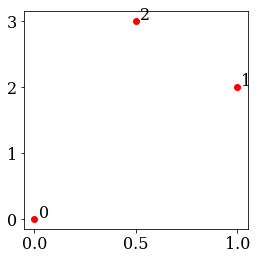

In [4]:
p0 = (0, 0)
p1 = (1, 2)
p2 = (0.5, 3)

print('0, 1, 2: {0:+d}'.format(orientation(p0, p1, p2)))
print('0, 2, 1: {0:+d}'.format(orientation(p0, p2, p1)))
print('1, 0, 2: {0:+d}'.format(orientation(p1, p0, p2)))
print('1, 2, 0: {0:+d}'.format(orientation(p1, p2, p0)))
print('2, 0, 1: {0:+d}'.format(orientation(p2, p0, p1)))
print('2, 1, 0: {0:+d}'.format(orientation(p2, p1, p0)))

plt.figure(figsize=(4, 4))

for i, (x, y) in enumerate([p0, p1, p2]):
    plt.plot(x, y, marker='o', color='red')
    plt.text(x+0.02, y+0.02, i, fontsize=16)

0, 1, 2: +0
0, 2, 1: +0
1, 0, 2: +0
1, 2, 0: +0
2, 0, 1: +0
2, 1, 0: +0


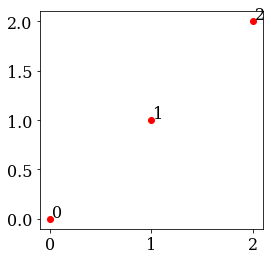

In [5]:
p0 = (0, 0)
p1 = (1, 1)
p2 = (2, 2)

print('0, 1, 2: {0:+d}'.format(orientation(p0, p1, p2)))
print('0, 2, 1: {0:+d}'.format(orientation(p0, p2, p1)))
print('1, 0, 2: {0:+d}'.format(orientation(p1, p0, p2)))
print('1, 2, 0: {0:+d}'.format(orientation(p1, p2, p0)))
print('2, 0, 1: {0:+d}'.format(orientation(p2, p0, p1)))
print('2, 1, 0: {0:+d}'.format(orientation(p2, p1, p0)))

plt.figure(figsize=(4, 4))

for i, (x, y) in enumerate([p0, p1, p2]):
    plt.plot(x, y, marker='o', color='red')
    plt.text(x+0.02, y+0.02, i, fontsize=16)

### Do lines intersect?

I got this solution from https://www.geeksforgeeks.org/check-if-two-given-line-segments-intersect/.

Let's say we have two lines $(p_0, p_1)$ and $(q_0, q_1)$, spanned by the points $p_0, p_1, q_0, 1_1$. We can use the orientation, $o(x_0, x_1, x_2)$, of different combinations of point tripplets to test if the line segments intersect.

The line segments intersect,

1. if in the non-collinear case the following two criteria are met
    1. $o(p_0, q_0, q_1) \neq o(p_1, q_0, q_1)$ and
    1. $o(q_0, p_0, p_1) \neq o(q_1, p_0, p_1)$; or
1. if in the collinear case the following three criteria are met
    1. $o(p_0, q_0, q_1) = o(p_1, q_0, q_1) = o(q_0, p_0, p_1) = o(q_1, p_0, p_1) = 0$, i.e. all points are collinear, and
    1. the x-projections of $(p_0, p_1)$ and $(q_0, q_1)$ intersect, and
    1. the y-projections of $(p_0, p_1)$ and $(q_0, q_1)$ intersect.

*Note 1:* When collinearity is given, the criteria 2-B and 2-C reduce to testing if one of the points $p_0$ or $p_1$ has its x-value between the x-values of $q_0$ and $q_1$ and the y-values accordingly. 

*Note 2:* In 2. we do not necessarily have to test that all points are collinear. It is sufficient that three points are collinear and that the center point's x- and y-projections intersect with the line spanned by the remaining two points. This covers the case that one line starts or ends on the other line, and they may or may not be collinear. This case is already covered by the criteria in 1. However, it might be simpler / faster to implement this approach.

In [6]:
def on_segment(p, q0, q1):
    if (p[0] >= min(q0[0], q1[0]) and
        p[0] <= max(q0[0], q1[0]) and 
        p[1] >= min(q0[1], q1[1]) and
        p[1] <= max(q0[1], q1[1])):
        do_intersect = True
    else:
        do_intersect = False
    
    return do_intersect

def intersect(p0, p1, q0, q1):
    o0 = orientation(p0, q0, q1)
    o1 = orientation(p1, q0, q1)
    o2 = orientation(q0, p0, p1)
    o3 = orientation(q1, p0, p1)
    
    if o0 != o1 and o2 != o3:
        do_intersect = True
    elif o0 == 0 and on_segment(p0, q0, q1):#(q0, p0, p1):
        do_intersect = True
    elif o1 == 0 and on_segment(p1, q0, q1):#(p0, q0, q1):
        do_intersect = True
    elif o2 == 0 and on_segment(q0, p0, p1):#(q1, p0, p1):
        do_intersect = True
    elif o3 == 0 and on_segment(q1, p0, p1):#(p1, q0, q1):
        do_intersect = True
    else:
        do_intersect = False
        
    return do_intersect

Intersect: True


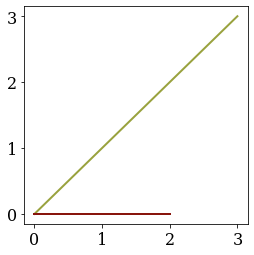

In [7]:
p0 = (0, 0)
p1 = (3, 3)
q0 = (2, 0)
q1 = (0, 0)

print('Intersect:', intersect(p0, p1, q0, q1))

plt.figure(figsize=(4, 4))

plt.plot([p0[0], p1[0]], [p0[1], p1[1]], linestyle='-')
plt.plot([q0[0], q1[0]], [q0[1], q1[1]], linestyle='-');

<div class="alert alert-block alert-warning">
<b>First, important note:</b> There is one special case, when one line fully overlaps with the other. Mathematically correct, this is seen as intersecting. However, in the context of the application here it should not. Imagine we have a lower declination limit; two points at the same declination that define the lower boundary over a range of hourangles. Furthermore let's consider a point at the same height, but outside of the polygon. There would be three lines that intersect with the extended line originating from the point. Thus, this point would be considered inside the polygon, because there is an uneven number of intersections. Therefore, collinear cases should generally be rejected. Note that collinearity can only occure for this specific scenario, because the line originating from the point is always horizontal. If outside of the polynome but at the hight of the lower limit, two intersections would be counted, and the point would be correctly identified as outside of the polygon. At the lower edge, one intersection would be counted, and the point would be correctly identified as inside the polygon. There is one exception: when the point is in the left corner of the lower limit. In this case, there will be two intersections - with the line going into the left point and the line starting from the right point. An easy solution to treat all points at the very limit equally would be to simply discard them all as outside. This can easily be done by returning False when the point is colliniar with any line and within the line boundaries.
</div>

This can be inplemented simply be reordering the conditionals and changing the output for the collinear intersections to `False`, and catching matching corner points:

In [8]:
def intersect(p0, p1, q0, q1):
    o0 = orientation(p0, q0, q1)
    o1 = orientation(p1, q0, q1)
    o2 = orientation(q0, p0, p1)
    o3 = orientation(q1, p0, p1)
    
    if o0 == 0 and on_segment(p0, q0, q1):#(q0, p0, p1):
        do_intersect = False
    elif o1 == 0 and on_segment(p1, q0, q1):#(p0, q0, q1):
        do_intersect = False
    elif o2 == 0 and on_segment(q0, p0, p1):#(q1, p0, p1):
        do_intersect = False
    elif o3 == 0 and on_segment(q1, p0, p1):#(p1, q0, q1):
        do_intersect = False
    elif o0 != o1 and o2 != o3:
        do_intersect = True
    else:
        do_intersect = False
        
    return do_intersect

Intersect: False


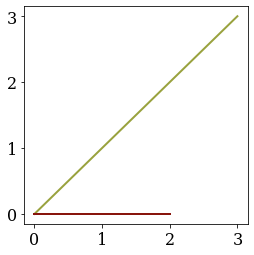

In [9]:
p0 = (0, 0)
p1 = (3, 3)
q0 = (2, 0)
q1 = (0, 0)

print('Intersect:', intersect(p0, p1, q0, q1))

plt.figure(figsize=(4, 4))

plt.plot([p0[0], p1[0]], [p0[1], p1[1]], linestyle='-')
plt.plot([q0[0], q1[0]], [q0[1], q1[1]], linestyle='-');

### Is a point in the polygon?

I got this solution from https://www.geeksforgeeks.org/how-to-check-if-a-given-point-lies-inside-a-polygon/.

The simple idea is, we draw a line from the point to the highest x-value of the polygon at constant y. We iterate through all lines of the polygon, and count the number of lines that intersect with the line extending from the point. If the number is even the point is outside of the polygon, if uneven it is within.

<div class="alert alert-block alert-warning">
<b>Second, important note:</b> There is still one special case, in the same scenario as above that the lower boundary is horizontal, but now the point is on the boundary. Now the point would be counted as intersecting with one line: the lower boundary line it is on is not counted, but it is intersecting with the next line. With an intersection count of 1 it would be considered inside the polygon. This can easily be solved by first checking whether or not the point is within the outermost bounds of the polygon; i.e. if we draw a rectangle around the polygon that touches the polygon with each side. If the point is at one of these bounds we count it as outside, that removes the noted issue. Also, it reduces calculation costs, because in those easy cases, there is no need to do all the orientation and on-segment calculations.
</div>

<div class="alert alert-block alert-warning">
<b>Third, important note:</b> When we extend a horizontal line from the point to the right, we need to extend it beyond the polygon (to any arbitrary point). If we use the x-coordinate of the right most point, we may run into an issue again, if the right most boundary is vertical and would not be counted as intersecting with the horizontal line; which would lead to false classifications as outside the polygon. Therefore, I use the `+ 1` in `p1 = (polygon_x_max + 1, p0[1])`.
</div>

In [13]:
def inside_polygon(p, polygon):
    
    # check if the point is within the outermost bounds:
    polygon_x = [q[0] for q in polygon]
    polygon_x_min = min(polygon_x)
    polygon_x_max = max(polygon_x)
    
    if p[0] <= polygon_x_min or p[0] >= polygon_x_max:
        return False
    
    polygon_y = [q[1] for q in polygon]
    polygon_y_min = min(polygon_y)
    polygon_y_max = max(polygon_y)
    
    if p[1] <= polygon_y_min or p[1] >= polygon_y_max:
        return False
    
    # extend line from point and count intersections:
    p0 = p
    p1 = (polygon_x_max + 1, p0[1])
    
    count_intersections = 0

    for i, (q0, q1) in enumerate(zip(polygon[:-1], polygon[1:])):
        
        # check if point, start point of this segment, and end point of previous segment are on same height:
        if i > 0 and p0[1] == q0[1] and p0[1] == polygon[i-1][1]:
            continue
        
        count_intersections += intersect(p0, p1, q0, q1)

    is_inside = bool(count_intersections % 2)
    
    return is_inside

Is inside: False


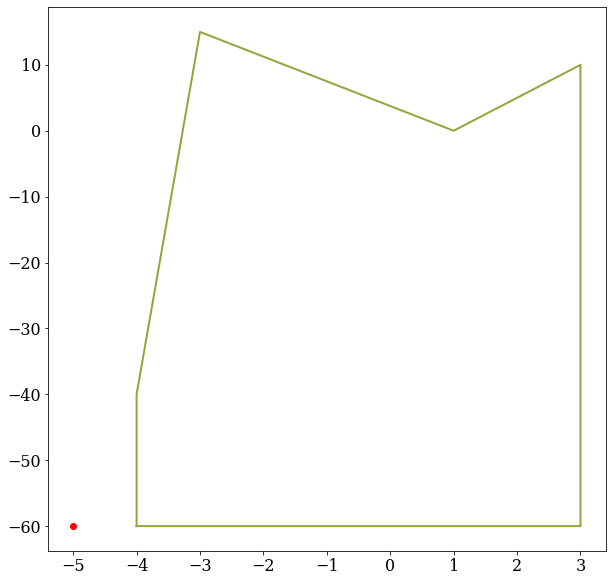

In [14]:
polygon = [(-4, -60), (-2, -60), (1, -60), (3, -60), (3, 10), (1, 0), (-3, 15), (-4, -40)]
polygon.append(polygon[0])
point = (-5, -60.0)

print('Is inside:', inside_polygon(point, polygon))

polygon_ar = np.array(polygon)
plt.plot(polygon_ar[:,0], polygon_ar[:,1], linestyle='-')
plt.plot(point[0], point[1], marker='o', color='red');

0
0
0
0
0
0
0
Is inside: False


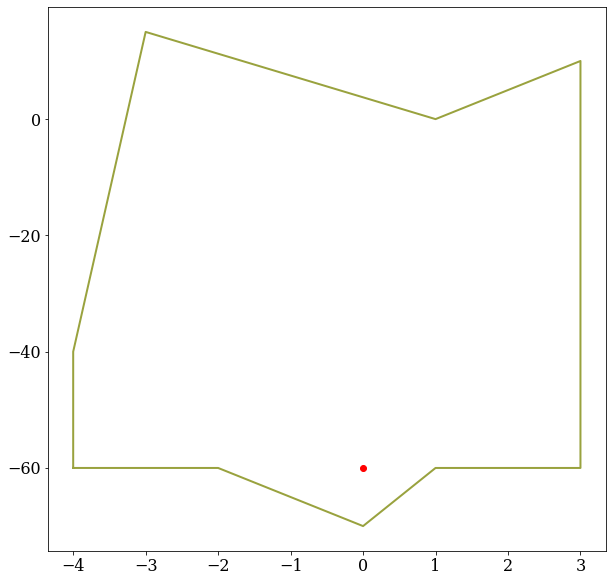

In [15]:
polygon = [(-4, -60), (-2, -60), (0, -70), (1, -60), (3, -60), (3, 10), (1, 0), (-3, 15), (-4, -40)]
polygon.append(polygon[0])
point = (0, -60.0)

print('Is inside:', inside_polygon(point, polygon))

polygon_ar = np.array(polygon)
plt.plot(polygon_ar[:,0], polygon_ar[:,1], linestyle='-')
plt.plot(point[0], point[1], marker='o', color='red');

## Implementation of the constraint class

In [16]:
%load_ext autoreload
%autoreload 2

In [17]:
from constraints import PolyHADecLimit

In [18]:
lat = Angle('-32:22:46 deg')
lon = Angle('20:48:38.5 deg')
height = 1798.
loc = EarthLocation(lat=lat, lon=lon, height=height)

In [19]:
duration = np.arange(0, 24., 0.5) * u.h
time = Time('2022-08-01T00:00:00.0', location=loc) + duration
frame = AltAz(obstime=time, location=loc)
#lst = time.sidereal_time('apparent')
lst = frame.obstime.sidereal_time('apparent')

In [20]:
source_coord = SkyCoord('15:00:00', '-60:00:00 deg', unit=('hourangle', 'deg'))
hourangle = (source_coord.ra - lst).hourangle
hourangle = (12. + hourangle) % 24. - 12.
dec = np.ones(hourangle.size) * source_coord.dec.deg
points = list(zip(hourangle, dec))

In [21]:
polygon = [(-4, -60), (-2, -60), (0, -70), (1, -60), (3, -60), (3, 10), (1, 0), (-3, 15), (-4, -40)]

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


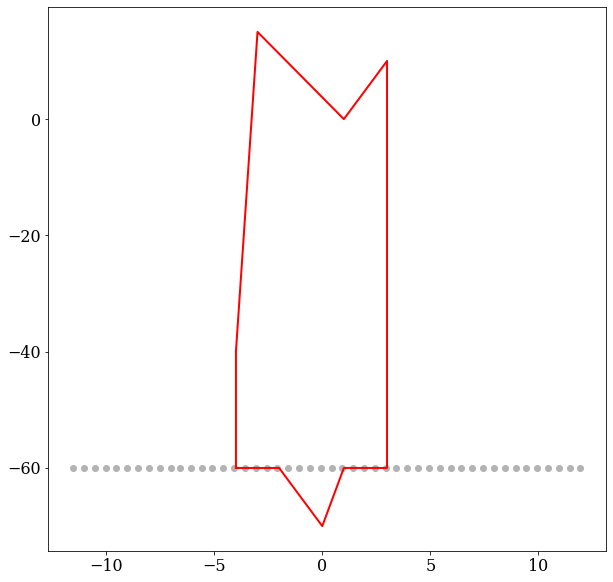

In [22]:
is_inside = np.zeros(len(points), dtype=bool)

for i, point in enumerate(points):
    is_inside[i] = inside_polygon(point, polygon+polygon[:1])

polygon_ar = np.array(polygon + polygon[:1])
plt.plot(polygon_ar[:,0], polygon_ar[:,1], linestyle='-', color='r', zorder=1)
plt.plot(hourangle[is_inside], dec[is_inside], marker='o', color='0.2', ls='None', zorder=0)
plt.plot(hourangle[~is_inside], dec[~is_inside], marker='o', color='0.7', ls='None', zorder=0);

In [23]:
constraint = PolyHADecLimit(polygon)
is_inside = constraint.get(source_coord, frame)

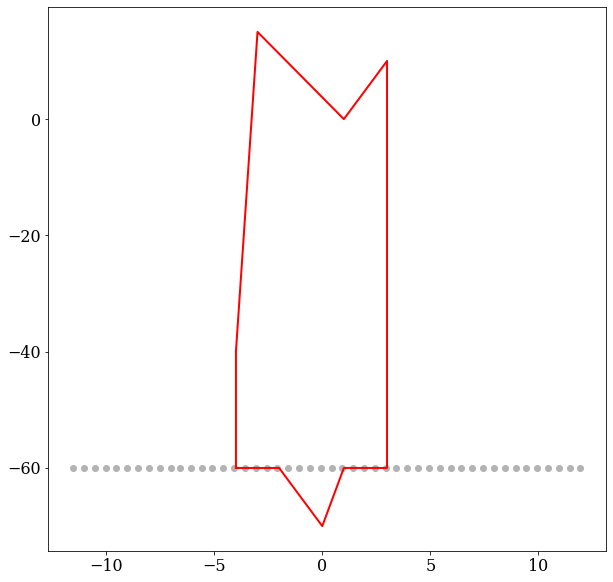

In [24]:
polygon_ar = np.array(polygon + polygon[:1])
plt.plot(polygon_ar[:,0], polygon_ar[:,1], linestyle='-', color='r', zorder=1)
plt.plot(hourangle[is_inside], dec[is_inside], marker='o', color='0.2', ls='None', zorder=0)
plt.plot(hourangle[~is_inside], dec[~is_inside], marker='o', color='0.7', ls='None', zorder=0);

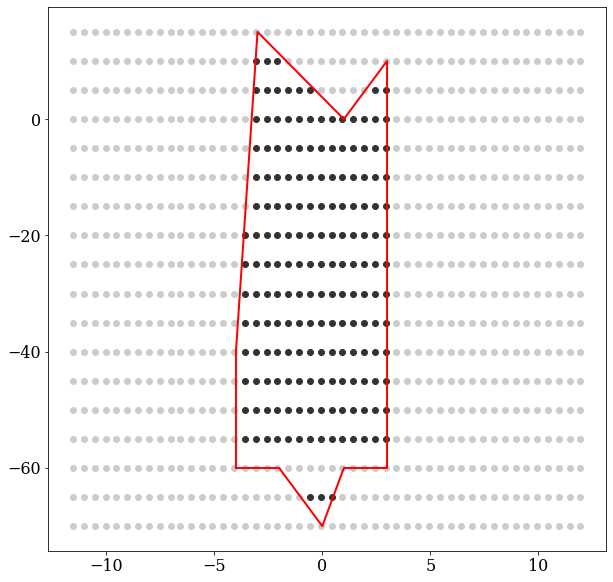

In [25]:
for dec in np.arange(-70, 20, 5):
    source_coord = SkyCoord('15:00:00', dec, unit=('hourangle', 'deg'))
    is_inside = constraint.get(source_coord, frame)
    hourangle = (source_coord.ra - lst).hourangle
    hourangle = (12. + hourangle) % 24. - 12.
    dec = np.ones(hourangle.size) * source_coord.dec.deg
    
    plt.plot(hourangle[is_inside], dec[is_inside], marker='o', color='0.2', ls='None', zorder=0)
    plt.plot(hourangle[~is_inside], dec[~is_inside], marker='o', color='0.8', ls='None', zorder=0)
    
polygon_ar = np.array(polygon + polygon[:1])
plt.plot(polygon_ar[:,0], polygon_ar[:,1], linestyle='-', color='r', zorder=1);

<div class="alert alert-block alert-danger">
Damn. Still buggy!
</div>

https://towardsdatascience.com/is-the-point-inside-the-polygon-574b86472119?gi=21a11464d505
https://en.wikipedia.org/wiki/Point_in_polygon
https://en.wikipedia.org/wiki/Winding_number

## Measured limits

Measurements of the Southerland telescope motion constraints with a model of WALOP-S attached are discussed here: https://docs.google.com/document/d/1KAde-k1-gXwztd_dC7hIrcBt5zLO1dBLvoILuaj8oKc/edit#

I extracted the three tables into text files. Load limits:

In [ ]:
limits_v1 = pd.read_csv('walops_constraints/limits_v1.dat', delimiter=',').drop(columns='Sr. No').rename(columns={'Hour Angle':'HA', 'Declination (in deg)': 'Dec'})
limits_v1

In [ ]:
limits_v2 = pd.read_csv('walops_constraints/limits_v2.dat', delimiter=',').drop(columns='Sr. No').rename(columns={'Hour Angle':'HA', 'Declination (in deg)': 'Dec'})
limits_v2

In [ ]:
limits_v3 = pd.read_csv('walops_constraints/limits_v3.dat', delimiter=',').drop(columns='Sr. No').rename(columns={'Hour Angle':'HA', 'Declination (in deg)': 'Dec'})
limits_v3

Convert to astropy.Angle:

In [ ]:
limits_v1_ha = Angle(limits_v1['HA'], unit='hourangle')
limits_v1_dec = Angle(limits_v1['Dec'], unit='deg')
limits_v2_ha = Angle(limits_v2['HA'], unit='hourangle')
limits_v2_dec = Angle(limits_v2['Dec'], unit='deg')
limits_v3_ha = Angle(limits_v3['HA'], unit='hourangle')
limits_v3_dec = Angle(limits_v3['Dec'], unit='deg')

## Show limits

In [ ]:
plt.plot(limits_v1_ha, limits_v1_dec, label='V1', linestyle='-')
plt.plot(limits_v2_ha, limits_v2_dec, label='V2', linestyle='--')
plt.plot(limits_v3_ha, limits_v3_dec, label='V3', linestyle=':')
plt.legend()
plt.xlabel('Hour angle [h]')
plt.ylabel('Declination [deg]')
plt.savefig('walops_constraints/plots/limits_all.png');

In [ ]:
plt.plot(limits_v1_ha, limits_v1_dec)
plt.xlabel('Hour angle [h]')
plt.ylabel('Declination [deg]')
plt.savefig('walops_constraints/plots/limits_v1.png');

In [ ]:
plt.plot(limits_v2_ha, limits_v2_dec)
plt.xlabel('Hour angle [h]')
plt.ylabel('Declination [deg]')
plt.savefig('walops_constraints/plots/limits_v2.png');

In [ ]:
plt.plot(limits_v3_ha, limits_v3_dec, linestyle='None', marker='o')
plt.xlabel('Hour angle [h]')
plt.ylabel('Declination [deg]')
plt.savefig('walops_constraints/plots/limits_v3.png');